In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt

sys.path.insert(0, './TetrisEnv')
from TetrisBattle.envs.tetris_env import TetrisSingleEnv, TetrisEnv
from TetrisBattle import *
# %pip install -e ./TetrisEnv
# import TetrisBattle

pygame 2.5.2 (SDL 2.28.3, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from gym.wrappers import GrayScaleObservation
from preprocessing.EensyWeensy import MakeEensyWeensy
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# from gym import make
# env = make('SinglePTetris-v0')
env = TetrisSingleEnv()

In [4]:
from gym import ActionWrapper
from gym.spaces import Discrete
class ReduceActions(ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = Discrete(4)
    def action(self, act):
        if act == 0:
            return 2 # drop
        if act == 1:
            return 3 # rotate right
        if act == 2:
            return 5 # right
        if act == 3:
            return 6 # left

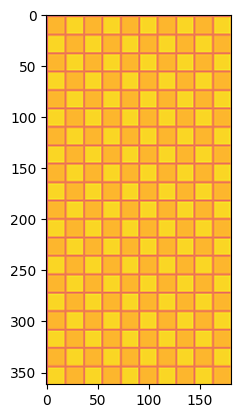

In [5]:
env = GrayScaleObservation(env, keep_dim=True)
env = MakeEensyWeensy(env, cut_in_half=True, scale=1)
env = ReduceActions(env)
env = DummyVecEnv([lambda: env])
#env = VecFrameStack(env, 4, channels_order="last")
ob = env.reset()
plt.imshow(ob[0,:,:,0], cmap="plasma")

In [6]:
import os 
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_checker import check_env
import torch
print(torch.cuda.is_available())
check_env(TetrisSingleEnv())

True


In [7]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [8]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [9]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [10]:
try:
    del model
except NameError:
    pass
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=1e-3, n_steps=64, device="cuda") 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [11]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/PPO_53
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | -87      |
| time/              |          |
|    fps             | 45       |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 64       |
---------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 40        |
|    ep_rew_mean          | -87       |
| time/                   |           |
|    fps                  | 37        |
|    iterations           | 2         |
|    time_elapsed         | 3         |
|    total_timesteps      | 128       |
| train/                  |           |
|    approx_kl            | 0.3221713 |
|    clip_fraction        | 0.527     |
|    clip_range           | 0.2       |
|    entropy_loss         | -1.29     |
|    explained_variance   | -0.00243  |
|    learning_rate        | 0.001  

KeyboardInterrupt: 

In [ ]:
model = PPO.load('./train/best_model_10000')
#env = TetrisSingleEnv()
state = env.reset()

for i in range(0, 10000):
    action, _ = model.predict(state)
    #print(action)
    state, reward, done, info = env.step(action)
    env.render()

env.close()